# 아파트 분양가격 예측하기
- 가설1 : 금리, 소비자물가지수, 산업생산지수, 부동산 정책에 관한 이슈가 지역별 아파트 분양가격에 영향을 미치며,
    선형회귀분석을 통해 가격을 설명할 수 있다.
- 가설 2: 서울과 그 외의 지역의 아파트 분양가격은 유의미하게 다르다
- 가설 3: 지역명, 규모구분이 아파트 분양가격에 영향을 미친다.(마지막 모델링이 R-Squere값이 약 0.91로 높게 나오고, 서울인지 아닌지의 여부가 아파트 분양가격 예측에 매우 도움이 된다는 결론을 얻었다. 이걸 가설로 바꾸고 싶은데... 말을 다듬을 필요가 있다.)


## 분석단계
1. 데이터 탐색 및 수집 
2. 데이터 전처리
    - 방법 1: python으로 가공
    - 방법 2: MySQL로 가공
3. 회귀분석
4. 결론

## 1. 데이터 탐색 및 수집

### 주어진 과제 데이터
- 전국 평균 분양가격(2019년 9월) (출처 : 공공데이터 포탈(DATA))

### 추가한 데이터
- cofix : 금리 (출처 : 은행연합회소비자포탈)
    - 은행들이 기준금리에 자금 조달 비용을 반영해 산출하는 주택담보대출 금리
- cpi : 소비자물가지수(출처 : 국가통계포탈(KOSIS))
    - 일반 도시 가계가 소비생활을 영위하기 위하여 구입하는 소비재와 서비스의 가격변동을 나타내는 지수
    - 2017년 = 100 
- iaip : 산업생산지수 (출처 : 이나라지표)
    - 우리나라 경제전체의 모든 산업을 대상으로 재화와 용역에 대한 생산활동의 흐름과 변화를 월별지수로 나타낸 것
    - 2015 년 = 100
- googletrend : 구글 "주택정책" 검색 비율 (출처 : 구글트랜드)
    - 주택정책에 대한 이슈를 수치화하기 위한 데이터로 사용
    - 2015년 1월~ 2019년 9월 중 가장 검색을 많이했을때의 검색량 = 100


### 데이터 설명
- COFIX 금리:은행들이 기준금리에 자금 조달 비용을 반영해 산출하는 주택담보대출 금리다

#### 과제 데이터: 전국 평균 분양가격(2019년 9월까지)

In [100]:
df_1= pd.read_csv(
 "주택도시보증공사_전국 평균 분양가격(2019년 9월).csv", encoding='euc-kr'
)

df_1.tail()

,지역명,규모구분,연도,월,분양가격(㎡)
4075,제주,전체,2019,9,3869
4076,제주,전용면적 60㎡이하,2019,9,3804
4077,제주,전용면적 60㎡초과 85㎡이하,2019,9,3884
4078,제주,전용면적 85㎡초과 102㎡이하,2019,9,NaN
4079,제주,전용면적 102㎡초과,2019,9,3601


In [101]:
# 연도, 월을 키값으로 다른 데이터 프레임들을 추가할 예정
# date 칼럼 생성
df_1["date"]=df_1["연도"]*100+df_1["월"]
df_1["date"]=df_1["date"].apply(str)
df_1.tail()

,지역명,규모구분,연도,월,분양가격(㎡),date
4075,제주,전체,2019,9,3869,201909
4076,제주,전용면적 60㎡이하,2019,9,3804,201909
4077,제주,전용면적 60㎡초과 85㎡이하,2019,9,3884,201909
4078,제주,전용면적 85㎡초과 102㎡이하,2019,9,NaN,201909
4079,제주,전용면적 102㎡초과,2019,9,3601,201909


In [102]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 6 columns):
지역명        4080 non-null object
규모구분       4080 non-null object
연도         4080 non-null int64
월          4080 non-null int64
분양가격(㎡)    3827 non-null object
date       4080 non-null object
dtypes: int64(2), object(4)
memory usage: 191.3+ KB


In [103]:
#NAN값 삭제
df_1=df_1[df_1["분양가격(㎡)"].notnull()]
# "  " 삭제
df_1=df_1[df_1["분양가격(㎡)"]!="  "]
#분양가격 숫자형 데이터로 바꾸기
# result["분양가격(㎡)"] = pd.to_numeric(result["분양가격(㎡)"], errors='coerce')
df_1["분양가격(㎡)"]=df_1["분양가격(㎡)"].apply(lambda x: x.replace(",",""))
df_1["분양가격(㎡)"]=df_1["분양가격(㎡)"].apply(lambda x: x.replace("-",""))
df_1=df_1[df_1["분양가격(㎡)"]!=""]


In [104]:
df_1["분양가격(㎡)"].astype("int")[:3]

0    5841
1    5652
2    5882
Name: 분양가격(㎡), dtype: int32

In [105]:
df_1.head()

,지역명,규모구분,연도,월,분양가격(㎡),date
0,서울,전체,2015,10,5841,201510
1,서울,전용면적 60㎡이하,2015,10,5652,201510
2,서울,전용면적 60㎡초과 85㎡이하,2015,10,5882,201510
3,서울,전용면적 85㎡초과 102㎡이하,2015,10,5721,201510
4,서울,전용면적 102㎡초과,2015,10,5879,201510


In [106]:
df_1.to_csv('df_1.csv',sep=",",index= False)

In [8]:
#df_1 csv로 저장하기
df_1.to_csv('df_1.csv',sep=",",index= False)

## 2. 데이터 전처리(python.ver)

In [9]:
# 1) COFIX 금리
cofix= pd.read_csv(
 "Cofix.csv", encoding='euc-kr',header=1
)
cofix_df=cofix[cofix.columns[1:3]]
cofix_df.sort_values(["대상월"], ascending=True, inplace=True)
cofix_df=cofix_df[cofix_df["대상월"]!="2014/12"]
cofix_df.reset_index(drop=True, inplace=True)
cofix_df.tail()

,대상월,신규취급액기준 COFIX
52,2019/05,1.85
53,2019/06,1.78
54,2019/07,1.68
55,2019/08,1.52
56,2019/09,1.57


In [10]:
#날짜(대상월) 형식 맞추고 "date"로 칼럼명 변경
cofix_df['대상월']=cofix_df['대상월'].astype("str")
cofix_df['대상월']=cofix_df['대상월'].apply(lambda x: x.replace("/",""))
cofix_df.sort_values(["대상월"], ascending=True,inplace=True)
cofix_df.columns=["date",'신규취급액기준 COFIX']
cofix_df.tail()

,date,신규취급액기준 COFIX
52,201905,1.85
53,201906,1.78
54,201907,1.68
55,201908,1.52
56,201909,1.57


In [18]:
# 2) 소비자물가지수 
cpi= pd.read_csv(
 "cpi.csv", encoding='euc-kr',header=0
)
cpi_df=cpi[["기간","총지수"]]
cpi_df["기간"]=(cpi_df["기간"]*100) #2015.1, 2016.1 로 되어있는 기간이 있어서 수정
cpi_df.columns=["date",'CPI총지수'] #칼럼명 바꾸기
cpi_df[:10]

,date,CPI총지수
0,201501.0,99.49
1,201502.0,99.56
2,201503.0,99.47
3,201504.0,99.63
4,201505.0,99.82
5,201506.0,99.83
6,201507.0,100.26
7,201508.0,100.51
8,201509.0,100.36
9,201510.0,100.33


In [22]:
# 날짜('date') 형식 맞추기
cpi_df['date']=cpi_df['date'].astype('int')
cpi_df['date']=cpi_df['date'].astype('str')
cpi_df.sort_values(["date"], ascending=True,inplace=True)
cpi_df.tail()

,date,CPI총지수
52,201905,105.31
53,201906,105.17
54,201907,104.91
55,201908,105.21
56,201909,105.57


In [27]:
# 3) 산업생산지수(index of Industrial Production)
iaip= pd.read_csv(
 "iaip.csv", encoding='euc-kr', header=0)
iaip=iaip.T
iaip.columns=["전산업생산지수(원지수)","전월동기대비","광공업","건설업","서비스업","공공행정"] #나중에 뭘 쓸지 몰라서 우선 모두 표시
iaip=iaip.drop(iaip.index[0])
iaip_df=pd.DataFrame(iaip["전산업생산지수(원지수)"]).reset_index() 
iaip_df.head()

,index,전산업생산지수(원지수)
0,201501월,95.6
1,201502월,91
2,201503월,101.6
3,201504월,99.6
4,201505월,97.9


In [28]:
#날짜(index) 형식 맞추기, 칼럼명 바꾸기
iaip_df['index']=iaip_df['index'].apply(lambda x: x.replace("월",""))
iaip_df.sort_values(["index"], ascending=True,inplace=True)
iaip_df.columns=["date",'전산업생산지수(원지수)'] #칼럼명 바꾸기
iaip_df.head()

,date,전산업생산지수(원지수)
0,201501,95.6
1,201502,91
2,201503,101.6
3,201504,99.6
4,201505,97.9


In [29]:
# 4) 주택정책에 관한 구글 트랜드 검색값
google= pd.read_csv(
 "googletrend.csv", encoding='utf-8')
google.head()

,date,google
0,2015-01-04,29
1,2015-01-11,29
2,2015-01-18,0
3,2015-01-25,87
4,2015-02-01,59


In [30]:
#날짜(index) 형식 맞추기
google["date"]=google["date"].apply(lambda x: x[:4]+x[5:7])
google.head()

,date,google
0,201501,29
1,201501,29
2,201501,0
3,201501,87
4,201502,59


In [31]:
# 같은 date끼리 groupby 하기
google_1=google.groupby("date").agg("mean").reset_index()
google_1.sort_values(["date"], ascending=True,inplace=True)
google_1.head()

,date,google
0,201501,36.25
1,201502,22.25
2,201503,29.40
3,201504,53.75
4,201505,25.40


In [33]:
#추가 데이터는 모두 2015년 1월~2019년 9월까지의 연도-월별 데이터이다.
#따라서 길이가 모두 같은것을 확인
len(cofix_df),len(cpi_df), len(iaip_df), len(google_1)

(57, 57, 57, 57)

In [35]:
#추가 데이터 merge (reduce함수로 누적해서 두개씩 merge)
# outer 병합을 하여 키값이 잘못입력되어있거나, 누락된 데이터는 없는지 검토
from functools import reduce
mg_ls=[cofix_df,cpi_df,iaip_df,google_1]
add_df=reduce(lambda x,y: pd.merge(x,y,how='outer'),mg_ls)
add_df

,date,신규취급액기준 COFIX,CPI총지수,전산업생산지수(원지수),google
0,201501,2.08,99.49,95.6,36.25
1,201502,2.03,99.56,91,22.25
2,201503,1.91,99.47,101.6,29.40
3,201504,1.77,99.63,99.6,53.75
4,201505,1.75,99.82,97.9,25.40
5,201506,1.66,99.83,102.3,21.25
6,201507,1.56,100.26,98.7,24.00
7,201508,1.55,100.51,96.5,19.40
8,201509,1.54,100.36,100.5,28.25
9,201510,1.57,100.33,102.5,17.25


In [36]:
#csv 저장
add_df.to_csv('add_df.csv',sep=",",index= False)


#### 데이터 병합

In [ ]:
#add_df= pd.read_csv('add_df.csv')

In [1]:
# csv 파일 불러오기 
# 상기의 단계를 모두 run 하지 않아도 이후 단계를 진행할 수 있도록 하기 위함
add_df = pd.read_csv('add_df.csv')
df_1 = pd.read_csv( "df_1.csv")
df_1.tail()

,지역명,규모구분,연도,월,분양가격(㎡),date
3797,경남,전용면적 102㎡초과,2019,9,4303,201909
3798,제주,전체,2019,9,3869,201909
3799,제주,전용면적 60㎡이하,2019,9,3804,201909
3800,제주,전용면적 60㎡초과 85㎡이하,2019,9,3884,201909
3801,제주,전용면적 102㎡초과,2019,9,3601,201909


In [2]:
#date를 키값으로 merge
result=pd.merge(df_1,add_df)
result.head()

,지역명,규모구분,연도,월,분양가격(㎡),date,신규취급액기준 COFIX,CPI총지수,전산업생산지수(원지수),google
0,서울,전체,2015,10,5841,201510,1.57,100.33,102.5,17.25
1,서울,전용면적 60㎡이하,2015,10,5652,201510,1.57,100.33,102.5,17.25
2,서울,전용면적 60㎡초과 85㎡이하,2015,10,5882,201510,1.57,100.33,102.5,17.25
3,서울,전용면적 85㎡초과 102㎡이하,2015,10,5721,201510,1.57,100.33,102.5,17.25
4,서울,전용면적 102㎡초과,2015,10,5879,201510,1.57,100.33,102.5,17.25


In [3]:
# 분양가격
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3802 entries, 0 to 3801
Data columns (total 10 columns):
지역명              3802 non-null object
규모구분             3802 non-null object
연도               3802 non-null int64
월                3802 non-null int64
분양가격(㎡)          3802 non-null int64
date             3802 non-null int64
신규취급액기준 COFIX    3802 non-null float64
CPI총지수           3802 non-null float64
전산업생산지수(원지수)     3802 non-null float64
google           3802 non-null float64
dtypes: float64(4), int64(4), object(2)
memory usage: 326.7+ KB


In [9]:
# 컬럼 순서 변경
result=result[["분양가격(㎡)","지역명","규모구분","date","신규취급액기준 COFIX","CPI총지수","전산업생산지수(원지수)","google"]]
result.head()

,분양가격(㎡),지역명,규모구분,date,신규취급액기준 COFIX,CPI총지수,전산업생산지수(원지수),google
0,5841,서울,전체,201510,1.57,100.33,102.5,17.25
1,5652,서울,전용면적 60㎡이하,201510,1.57,100.33,102.5,17.25
2,5882,서울,전용면적 60㎡초과 85㎡이하,201510,1.57,100.33,102.5,17.25
3,5721,서울,전용면적 85㎡초과 102㎡이하,201510,1.57,100.33,102.5,17.25
4,5879,서울,전용면적 102㎡초과,201510,1.57,100.33,102.5,17.25


In [5]:
# 중간 save
result.to_csv('result.csv',sep=",",index= False)

### 3. 회귀분석
- 특정 지역만 선택하여 지역별 아파트 분양가격 회귀분석 실시
- 독립변수: ["분양가격(㎡)","date","신규취급액기준 COFIX","CPI총지수","전산업생산지수(원지수)","google"]
- 종속변수: 아파트 분양가격
- 분석단계
    - 서울(규모구분:전체) 데이터를 기준으로 회귀분석 모델링
    - 서울과 경기 데이터를 기준으로 회귀분석 모델링
    - 오차합 비교
    - 더 많은 지역을 포함한 후자의 모델이 오차합이 더 큰 경우 이유 분석

In [50]:
# 지역명:서울, 규모구분:전체 

seoul=result[(result["규모구분"]=="전체")&(result["지역명"]=="서울")]
seoul=seoul[["분양가격(㎡)","date","신규취급액기준 COFIX","CPI총지수","전산업생산지수(원지수)","google"]]
seoul.head()



,분양가격(㎡),date,신규취급액기준 COFIX,CPI총지수,전산업생산지수(원지수),google
0,5841,201510,1.57,100.33,102.5,17.25
81,6050,201511,1.66,100.18,101.6,31.60
162,6041,201512,1.72,100.55,112.3,21.75
243,6108,201601,1.65,100.63,97.0,10.40
324,6111,201602,1.57,101.03,93.4,13.00


In [51]:
seoul.to_csv('seoul.csv',sep=",",index= False)

In [52]:
#지역명: 서울,경기 규모구분:전체
seoul_kyungi=result[result["규모구분"]=="전체"]
a=seoul_kyungi[(seoul_kyungi["지역명"]=="서울")|(seoul_kyungi["지역명"]=="경기")]

seoul_kyungi=a[["분양가격(㎡)","date","신규취급액기준 COFIX","CPI총지수","전산업생산지수(원지수)","google"]]
seoul_kyungi.head()

,분양가격(㎡),date,신규취급액기준 COFIX,CPI총지수,전산업생산지수(원지수),google
0,5841,201510,1.57,100.33,102.5,17.25
10,3138,201510,1.57,100.33,102.5,17.25
81,6050,201511,1.66,100.18,101.6,31.60
91,3098,201511,1.66,100.18,101.6,31.60
162,6041,201512,1.72,100.55,112.3,21.75


In [53]:
seoul_kyungi.to_csv('seoul_kyungi.csv',sep=",",index= False)

In [77]:
#모델링 
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [78]:
df_x = seoul[seoul.columns[1:]]  #독립변수
df_y = seoul['분양가격(㎡)']  #종속변수()

In [79]:
train_x, test_x, train_y, test_y = train_test_split(
        df_x, df_y, test_size=0.1, random_state=1
)

In [80]:
#회귀분석
from sklearn.linear_model import LinearRegression
#클래스 객체 생성
model = LinearRegression(fit_intercept=True) 

# 모형 추정(상수항 결합을 자동으로 해줌)
model= model.fit(train_x, train_y)
# test하는 독립변수값을 넣었을때 예측된 분양가격 데이터
pred_y= model.predict(test_x)

In [81]:
seoul.head(1)

,분양가격(㎡),date,신규취급액기준 COFIX,CPI총지수,전산업생산지수(원지수),google
0,5841,201510,1.57,100.33,102.5,17.25


In [82]:
# 독립변수를 넣었을때 실제 분양가격과 비슷한 값이 나온다
model.predict([[201510,1.57,100.33,102.5,17.25]])

array([5601.75866812])

In [83]:
# test하는 독립변수값을 넣었을때 예측된 분양가격 데이터
len(pred_y)

5

In [84]:
# 실제 분양가격 데이터
len(test_y)

5

In [85]:
# Mean Absolute Error(MAE)
# 모델의 예측값과 실제값의 차이를 모두 더하여 n으로 나눈값
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, pred_y)
round(mae, 2)

287.77

In [86]:
#R-Square(결정계수): 회귀분석 모델의 적합도.
# 보통 0~1 값을 가지는데, 1에 가까울수록 적합도가 높다
model.score(test_x, test_y)

0.6202477378323401

In [90]:
# 추정한 가중치
col=["date","신규취급액기준 COFIX","CPI총지수","전산업생산지수(원지수)","google"]
coefs = pd.DataFrame(zip(col, model.coef_),columns = ["features","coefficients"])
coefs

,features,coefficients
0,date,7.974197
1,신규취급액기준 COFIX,-320.059949
2,CPI총지수,-214.804599
3,전산업생산지수(원지수),15.246677
4,google,-0.501512


#### 금리와 소비자물가지수가 강한 음의 상관관계를 보인다

#### 결론 1)
- 금리, 소비자물가지수, 산업생산지수, 부동산 정책에 관한 이슈를 기반으로 아파트 분양가격에 영향을 미치며,선형회귀분석을 통해 가격을 설명할 수 있다.
- model.predict를 사용하면 아파트 가격을 예측할 수 있다
- 단 , 이때의 오차는 약 277천원/㎡(?) 277만원/㎡(?) 이다
   
 

In [71]:
# 서울경기
df_x = seoul_kyungi[seoul_kyungi.columns[1:]]  #독립변수
df_y = seoul_kyungi['분양가격(㎡)']  #종속변수()
train_x, test_x, train_y, test_y = train_test_split(
        df_x, df_y, test_size=0.1, random_state=1
)

#클래스 객체 생성
model = LinearRegression(fit_intercept=True) 

# 모형 추정(상수항 결합을 자동으로 해줌)
model= model.fit(train_x, train_y)

# test하는 독립변수값을 넣었을때 예측된 분양가격 데이터
pred_y = model.predict(test_x)

In [72]:
# Mean Absolute Error(MAE)
# 모델의 예측값과 실제값의 차이를 모두 더하여 n으로 나눈값
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, pred_y)
round(mae, 2)

1588.69

In [73]:
#R-Square(결정계수): 회귀분석 모델의 적합도.
# 보통 0~1 값을 가지는데, 1에 가까울수록 적합도가 높다
# 음수인 경우 오차제곱이 편차제곱보다 큰 경우이다. 즉 그냥 mean value로 예측하는 모델보다 회귀분석 모델의 예측성능이 더 낮다는 의미이다

model.score(test_x, test_y)

-0.04210364171425307

#### 서울 모델링과 서울&경기 모델링 한 결과를 비교하면 후자의 경우 MAE가 더 커진것을 알 수 있다.
#### 그 이유는 지역별 분양가격에서 힌트를 찾을 수 있다.


In [27]:
result_pv=result.pivot_table("분양가격(㎡)",["date"],["지역명"], aggfunc=np.mean)
result_pv.index=result_pv.index.astype("str")
result_pv.head(3)

지역명,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
date,,,,,,,,,,,,,,,,,
201510,2179.4,3335.8,2547.8,2205.4,2370.666667,2629.4,2482.0,3103.6,5795.0,2641.4,2831.2,3344.6,2080.0,2172.8,2403.50,2318.2,2091.0
201511,2177.6,3298.8,2568.6,2294.4,2373.000000,2671.6,2482.0,3169.2,6395.4,2655.8,2842.4,3316.8,2050.4,2180.4,2403.50,2282.0,2017.0
201512,2177.6,3420.8,2573.8,2285.8,2453.333333,2898.0,2482.0,3161.2,6278.4,2671.0,2842.4,3316.8,2050.4,2110.8,2421.25,2390.6,2100.0


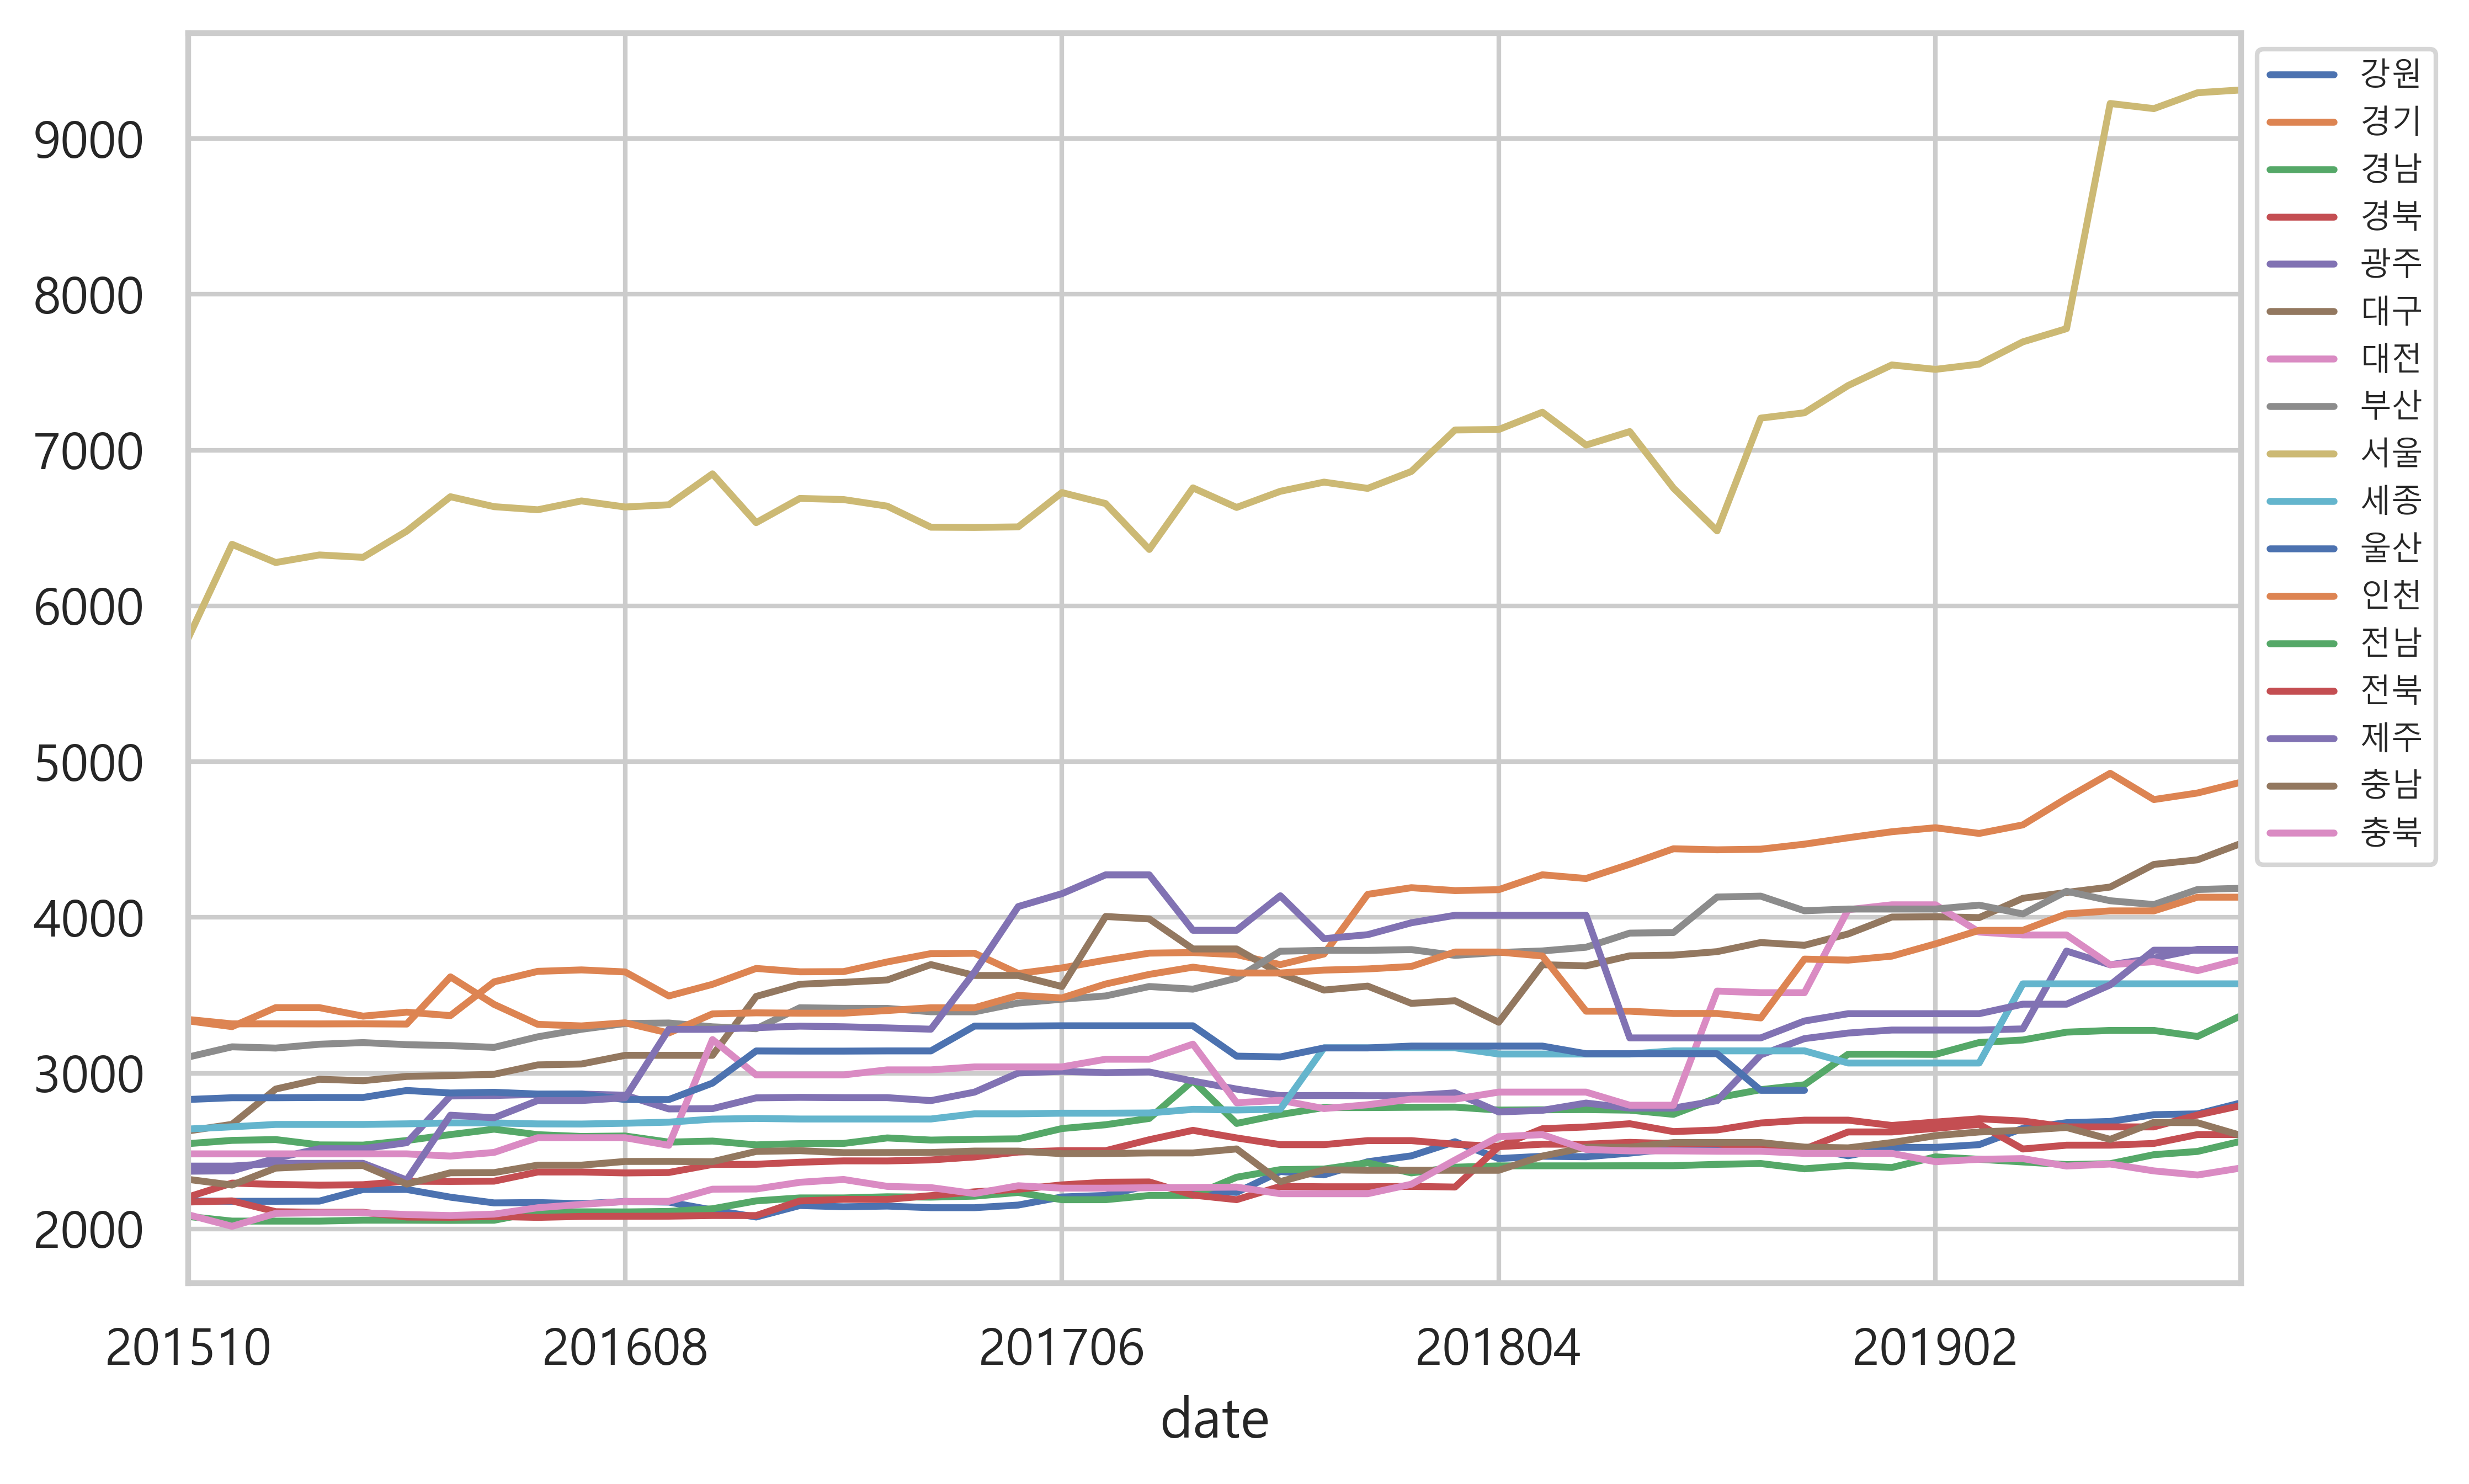

In [28]:
result_pv.plot()
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize='x-small')
plt.show()

#### 결론 2) 서울의 분양가격이 확연하게 타 지역과 차이나기 때문에 함께 회귀분석 모델링을 하면 MAE가 커질 수 밖에 없다

#### dummy변수 넣어서 모델링

In [91]:
result= pd.read_csv( "result.csv")

In [92]:
one_hot_result= pd.get_dummies(result["지역명"])
one_hot_result.head()

,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [93]:
one_hot_result2= pd.get_dummies(result["규모구분"])
one_hot_result2.head(2)

,전용면적 102㎡초과,전용면적 60㎡이하,전용면적 60㎡초과 85㎡이하,전용면적 85㎡초과 102㎡이하,전체
0,0,0,0,0,1
1,0,1,0,0,0


In [94]:
one_hot_final=pd.concat([result,one_hot_result,one_hot_result2],axis=1)
one_hot_final=one_hot_final[one_hot_final['전체']==0]
one_hot_final=one_hot_final[['분양가격(㎡)', 'date', '신규취급액기준 COFIX', 'CPI총지수',
       '전산업생산지수(원지수)', 'google', '강원', '경기', '경남', '경북', '광주', '대구', '대전',
       '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북',
       '전용면적 102㎡초과', '전용면적 60㎡이하', '전용면적 60㎡초과 85㎡이하', '전용면적 85㎡초과 102㎡이하',
       ]]
one_hot_final.head()

,분양가격(㎡),date,신규취급액기준 COFIX,CPI총지수,전산업생산지수(원지수),google,강원,경기,경남,경북,...,인천,전남,전북,제주,충남,충북,전용면적 102㎡초과,전용면적 60㎡이하,전용면적 60㎡초과 85㎡이하,전용면적 85㎡초과 102㎡이하
1,5652,201510,1.57,100.33,102.5,17.25,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5882,201510,1.57,100.33,102.5,17.25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,5721,201510,1.57,100.33,102.5,17.25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5879,201510,1.57,100.33,102.5,17.25,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,3488,201510,1.57,100.33,102.5,17.25,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [95]:
#모델링 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
df_x = one_hot_final[one_hot_final.columns[1:]]  #독립변수
df_y = one_hot_final['분양가격(㎡)']  #종속변수

train_x, test_x, train_y, test_y = train_test_split(
        df_x, df_y, test_size=0.1, random_state=1
)

#회귀분석
from sklearn.linear_model import LinearRegression
#클래스 객체 생성
model = LinearRegression(fit_intercept=True) 

# 모형 추정(상수항 결합을 자동으로 해줌)
model= model.fit(train_x, train_y)
# test하는 독립변수값을 넣었을때 예측된 분양가격 데이터
pred_y= model.predict(test_x)

# Mean Absolute Error(MAE)
# 모델의 예측값과 실제값의 차이를 모두 더하여 n으로 나눈값
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, pred_y)
round(mae, 2)

252.54

In [96]:
#R-Square(결정계수): 회귀분석 모델의 적합도.
# 0~1 값을 가지는데, 1에 가까울수록 적합도가 높다
model.score(test_x, test_y)

0.9168854923735219

#### 결론) 더미변수를 모두 넣어서 모델링을 해보니 오차합이 seoul한것보다 더 낮게 나왔다
#### R-square 값도 0.91로 더 높은 적합도를 보여준다

In [101]:
col=[ 'date', '신규취급액기준 COFIX', 'CPI총지수',
       '전산업생산지수(원지수)', 'google', '강원', '경기', '경남', '경북', '광주', '대구', '대전',
       '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북',
       '전용면적 102㎡초과', '전용면적 60㎡이하', '전용면적 60㎡초과 85㎡이하', '전용면적 85㎡초과 102㎡이하',
       ]
coefs = pd.DataFrame(zip(col, model.coef_),columns = ["features","coefficients"])
coefs

,features,coefficients
0,date,2.526907
1,신규취급액기준 COFIX,-242.730948
2,CPI총지수,-10.500786
3,전산업생산지수(원지수),9.256322
4,google,0.309528
5,강원,-849.083983
6,경기,797.240934
7,경남,-403.165672
8,경북,-677.643159
9,광주,-240.905804


#### 지역과 금리가 큰 상관관계를 가진다는 것을 알 수있다
#### 특히 서울의 가중치가 상당히 큰 것으로 보아 서울인지 아닌지의 유무가 아파트 분양가격을 결정하는데 매우 큰 요소임을 알 수 있다
#### 이러한 이유로 두번째 모델(서울과 경기의 아파트 분양가격을 구분하지 않고 모델링)의 적합성이 매우 낮게 나오는 이유를 알 수 있다.
